In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from itertools import chain
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm
%matplotlib inline

In [2]:
p_common = {"b2":0, 'd1':1,'d2':1,'K1':1,'K2':1,'mu':0.1, 'V':100}
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}

In [3]:
def compat(a, delta_u): # compatibilités de quelqu'un de trait a avec quelqu'un de différence delta_u
    a = a * 2 - 1 # on met dans [-1, 1]
    if a >= 0:
        return np.exp(-a*delta_u*delta_u) # voir si on met un facteur devant le a
    else:
        return 1-np.exp(a*delta_u*delta_u) + np.exp(-1)

In [83]:
def stoch_round(x):
    if np.random.rand() > x - int(x):
        return int(x)
    else:
        return int(x)+1

In [86]:
compat(0, 0)

0.36787944117144233

In [146]:
def get_birth_rates(state, a1, a2, b1, b2, d1, d2, K1, K2, mu, V):
    trait_step = state.shape[0]
    u_vals = np.linspace(0, 1, trait_step) # Liste des valeurs du trait u.
    N_per_u = np.sum(state, axis=1) / V # Nombre d'individus avec chaque valeur de u (pour calculer F1 et F2).
    
    A1_per_u = a1 + b1*u_vals # Valeur de A1 pour chaque valeur de u.    
    F1 = (d1 * K1) / (d1 * K1 + np.dot(u_vals, np.multiply(N_per_u, A1_per_u)))

    A2_per_u = a2 + b2*u_vals # Valeur de A2 pour chaque valeur de u.
    F2 = (d2 * K2) / (d2 * K2 + np.dot(1 - u_vals, np.multiply(N_per_u, A2_per_u)))
    
    beta_per_u = np.multiply(u_vals, A1_per_u) * F1 + np.multiply(1-u_vals, A2_per_u) * F2
    
    #print(beta_per_u)
    
    return beta_per_u

In [150]:
def stochastic_simul(Tmax, nb_steps, state, birth_rates, mu, mutation_rate):
    """ Simulation stochastique avec l'algorithme de Gillespie.
    
    Paramètres :
        Tmax : temps final de la simulation.
        nb_steps : nombre d'étapes.
        state : np.ndarray de forme (trait_step, trait_step) représentant le nombre d'individus
                pour chaque couple (u, a) (u ligne, a colonne)
        get_birth_rates : fonction retournant le birth rate pour chaque u en fonction de l'état
        mu : taux de mortalité (indépendant des traits)
        
    """
    
    trait_step = state.shape[0] # combien de valeurs du trait on utilise
    dt = Tmax/nb_steps
    
    u_vals = np.linspace(0, 1, trait_step) # Liste des valeurs du trait u.
    a_vals = np.linspace(0, 1, trait_step) # Liste des valeurs du trait a.

    trajectory = np.zeros((nb_steps, trait_step, trait_step), dtype=int) # On sauvegarde l'état initial.
    
    for t in range(nb_steps):
        if t % 100 == 0:
            print('Étape {}, {:.1%}'.format(t, t/nb_steps))
        # on calcule tous les taux
        birth_rate_per_u = birth_rates(state)
        
        new_state = np.zeros((trait_step, trait_step))
        
        for u_i in range(trait_step):
            for a_i in range(trait_step):
                if state[u_i][a_i] > 0:
                    nb_repros = np.random.poisson(state[u_i][a_i]*birth_rate_per_u[u_i]*dt)
                    nb_morts = np.random.poisson(state[u_i][a_i]*mu*dt)
                    
                    for i in range(nb_repros):
                        # on trouve le nouveau partenaire avec proba N(u_i, a_i) * beta(u_i, a_i)
                        probas = (state.transpose() * birth_rate_per_u).transpose()
                        masse_totale = np.sum(probas)
                        
                        # u_part et a_part : traits du partenaire sélectionné
                        cases_non_vides = [(u, a) for u in range(trait_step) for a in range(trait_step)
                                           if probas[u, a] > 0]
                        trouve = False
                        u_part = -1
                        a_part = -1
                        while not trouve:
                            r = np.random.random()
                            pos = np.random.randint(0, len(cases_non_vides))
                            u_part, a_part = cases_non_vides[pos]
                            if r*masse_totale < probas[u_part][a_part]:
                                trouve = True
                        
                        delta_u = u_vals[u_i] - u_vals[u_part]
                        proba_repro = compat(a_vals[a_i], delta_u) * compat(a_vals[a_part], delta_u)
                        
                        if np.random.binomial(1, proba_repro):
                            # héritage des traits des parents
                            nouv_u = stoch_round((u_i + u_part)/2)
                            nouv_a = stoch_round((a_i + a_part)/2)

                            # est-ce qu'on va muter
                            mute_u = np.random.random() < mutation_rate
                            mute_a = np.random.random() < mutation_rate
                            #mute_a = 0
                            augmente_u = 0
                            augmente_a = 0
                            if mute_u:
                                augmente_u = np.random.randint(0, 2) * 2 - 1
                            if mute_a:
                                augmente_a = np.random.randint(0, 2) * 2 - 1

                            nouv_u = min(max(nouv_u + augmente_u, 0), trait_step-1)
                            nouv_a = min(max(nouv_a + augmente_a, 0), trait_step-1)

                            new_state[nouv_u][nouv_a] += 1
                        
                    new_state[u_i][a_i] = max(state[u_i][a_i] + new_state[u_i][a_i] - nb_morts, 0)
                        
        trajectory[t, :, :] = state[:, :]
        state = new_state
        
    return trajectory

In [151]:
state = np.zeros((20, 20))
state[5, 10] = 200

In [152]:
traj = stochastic_simul(500, 5000, state, partial(get_birth_rates, **p_strong), p_strong["mu"], 0.2)

Étape 0, 0.0%
Étape 100, 2.0%
Étape 200, 4.0%
Étape 300, 6.0%
Étape 400, 8.0%
Étape 500, 10.0%
Étape 600, 12.0%
Étape 700, 14.0%
Étape 800, 16.0%
Étape 900, 18.0%
Étape 1000, 20.0%
Étape 1100, 22.0%
Étape 1200, 24.0%
Étape 1300, 26.0%
Étape 1400, 28.0%
Étape 1500, 30.0%
Étape 1600, 32.0%
Étape 1700, 34.0%
Étape 1800, 36.0%
Étape 1900, 38.0%
Étape 2000, 40.0%
Étape 2100, 42.0%
Étape 2200, 44.0%
Étape 2300, 46.0%
Étape 2400, 48.0%
Étape 2500, 50.0%
Étape 2600, 52.0%
Étape 2700, 54.0%
Étape 2800, 56.0%
Étape 2900, 58.0%
Étape 3000, 60.0%
Étape 3100, 62.0%
Étape 3200, 64.0%
Étape 3300, 66.0%
Étape 3400, 68.0%
Étape 3500, 70.0%
Étape 3600, 72.0%
Étape 3700, 74.0%
Étape 3800, 76.0%
Étape 3900, 78.0%
Étape 4000, 80.0%
Étape 4100, 82.0%
Étape 4200, 84.0%
Étape 4300, 86.0%
Étape 4400, 88.0%
Étape 4500, 90.0%
Étape 4600, 92.0%
Étape 4700, 94.0%
Étape 4800, 96.0%
Étape 4900, 98.0%


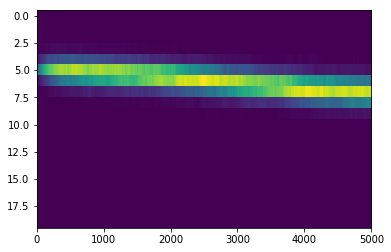

In [153]:
plt.imshow(np.sum(traj, axis = 2).transpose(), aspect='auto') # on somme sur a pour avoir (u, t)

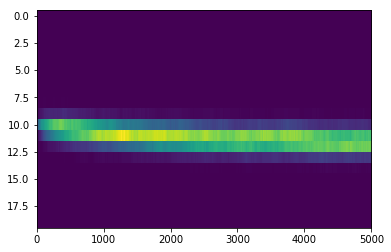

In [154]:
plt.imshow(np.sum(traj, axis = 1).transpose(), aspect='auto') # on somme sur u pour avoir (a, t)